- [paper](https://arxiv.org/pdf/1710.05941.pdf)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.python.ops.init_ops import glorot_normal_initializer
import numpy as np

In [2]:
def swish_beta(x, beta=1.0, dtype=tf.float32, name=None):
    with tf.name_scope(name, "Swish", [x]):
        tf_x = tf.convert_to_tensor(x, dtype=dtype, name="input")
        with tf.name_scope("Sigmoid"):
            sigmoid = tf.nn.sigmoid(beta*tf_x)
        sw_x = tf.multiply(sigmoid, x, name="output")
    return sw_x

In [3]:
def batch_norm_layer(inputs, is_training=None, name=None, decay=0.999, epsilon=1e-5):
    """
    Batch-Normalization Layer
    
    params
    ======
    - inputs: input Tensor
    - name(Optional): name of the layer
    - decay(Optional): decay rate of moving average of input moments
    - epsilon(Optional): epsilon to advoid dividing by 0.
    
    returns
    =======
    - is_training: a placeholder of type tf.bool. If the value is `True`, the
    layer will run in training phase, otherwise running in inference phase.
    - outputs: batch normalized outputs
    """
    if is_training is None:
        is_training = tf.placeholder(tf.bool, name="is_training")
    
    N_features = inputs.get_shape()[-1]
    scale = tf.Variable(tf.ones(N_features), dtype=tf.float32, name="scale")
    offset = tf.Variable(tf.ones(N_features), dtype=tf.float32, name="offset")
    
    moving_mean = tf.Variable(tf.zeros(N_features), 
                              trainable=False,
                              name="moving_mean")
    moving_vars = tf.Variable(tf.ones(N_features),
                              trainable=False,
                              name="moving_vars")
    
    def fn_inference(): 
        return tf.nn.batch_normalization(inputs,
                                         moving_mean,
                                         moving_vars,
                                         offset,
                                         scale,
                                         epsilon)
    
    # Follow the recommanded implementation in this issue 
    # https://github.com/tensorflow/tensorflow/issues/3287
    def fn_training():
        inputs_mean, inputs_vars = tf.nn.moments(inputs, [0])
        update_mean_op = tf.assign(moving_mean, decay*moving_mean+(1-decay)*inputs_mean)
        update_vars_op = tf.assign(moving_vars, decay*moving_vars+(1-decay)*inputs_vars)
        with tf.control_dependencies([update_mean_op, update_vars_op]):
            train_outputs = tf.nn.batch_normalization(inputs, 
                                                      inputs_mean, 
                                                      inputs_vars,
                                                      offset,
                                                      scale,
                                                      epsilon)
        return train_outputs
    
    outputs = tf.cond(is_training, 
                      true_fn=fn_training, 
                      false_fn=fn_inference, 
                      name=name)
    return outputs, is_training

### Experiment with Fashion MNIST

In [4]:
from fashion_mnist import read_data_sets, predict_labels

Using TensorFlow backend.


In [5]:
fashion_mnist = read_data_sets("fashion_data", one_hot=True)

Extracting fashion_data/train-images-idx3-ubyte.gz
Extracting fashion_data/train-labels-idx1-ubyte.gz
Extracting fashion_data/t10k-images-idx3-ubyte.gz
Extracting fashion_data/t10k-labels-idx1-ubyte.gz


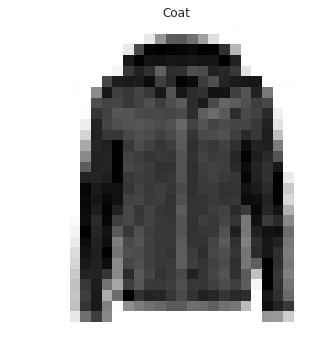

In [6]:
plt.axis('off')
plt.title(predict_labels(fashion_mnist.train.labels[0])[0])
_ = plt.imshow(fashion_mnist.train.images[0].reshape(28, 28))

In [7]:
def compute_accuracy(y1, y2):
    return (y1 == y2).mean()

In [8]:
np.random.seed(1111)

def init_fn(shape, dtype):
    np_v = np.random.randn(*shape)
    return tf.convert_to_tensor(np_v, dtype=dtype)

In [9]:
init = glorot_normal_initializer(seed=1111) 

In [10]:
# normal mlp
graph = tf.Graph()
with graph.as_default():
    is_training = tf.placeholder(tf.bool)
    x_ = tf.placeholder(tf.float32, shape=[None, 784])
    y_ = tf.placeholder(tf.float32, shape=[None, 10])
    
    # layer 1
    W1 = tf.Variable(init(shape=(784, 200), dtype=tf.float32))
    z1 = tf.matmul(x_, W1)
    a1, _ = batch_norm_layer(z1, is_training)
    l1 = tf.nn.relu(a1)
    
    # layer 2
    W2 = tf.Variable(init(shape=(200, 200), dtype=tf.float32))
    z2 = tf.matmul(l1, W2)
    a2, _ = batch_norm_layer(z2, is_training)
    l2 = tf.nn.relu(a2)
    
    # layer 3
    W3 = tf.Variable(init(shape=(200, 10), dtype=tf.float32))
    z3 = tf.matmul(l2, W3)
    y = tf.nn.softmax(z3)
    predict = tf.argmax(y, 1)
    
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=z3, labels=y_))
    train_op = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cross_entropy)

In [11]:
n_iterations = 40000
batch_size = 100

losses = [None for _ in range(n_iterations)]
accuracy = []

with tf.Session(graph=graph) as sess:
    tf.global_variables_initializer().run()
    
    for step in range(n_iterations):
        train_image, train_labels = fashion_mnist.train.next_batch(batch_size)
        feed_dict = { x_:train_image,
                      y_:train_labels,
                      is_training:True}
        _, l = sess.run([train_op, cross_entropy], feed_dict=feed_dict)
        losses[step] = l
        if (step+1) % 1000 == 0:
            feed_dict[x_] = fashion_mnist.test.images
            feed_dict[y_] = fashion_mnist.test.labels
            feed_dict[is_training] = False
            pred = sess.run(predict, feed_dict=feed_dict)
            acc = compute_accuracy(pred, np.argmax(fashion_mnist.test.labels, 1))
            accuracy.append(acc)
            print("Iteration {}: loss {:.4f}, test acuuracy {:.2f}%".format(step+1, l, acc*100))

Iteration 1000: loss 0.4078, test acuuracy 78.08%
Iteration 2000: loss 0.3467, test acuuracy 81.34%
Iteration 3000: loss 0.2845, test acuuracy 84.68%
Iteration 4000: loss 0.3190, test acuuracy 85.56%
Iteration 5000: loss 0.3604, test acuuracy 86.00%
Iteration 6000: loss 0.3497, test acuuracy 86.63%
Iteration 7000: loss 0.1438, test acuuracy 86.30%
Iteration 8000: loss 0.1506, test acuuracy 87.46%
Iteration 9000: loss 0.1993, test acuuracy 86.38%
Iteration 10000: loss 0.1400, test acuuracy 87.00%
Iteration 11000: loss 0.3223, test acuuracy 86.77%
Iteration 12000: loss 0.2027, test acuuracy 87.46%
Iteration 13000: loss 0.2442, test acuuracy 87.63%
Iteration 14000: loss 0.1367, test acuuracy 87.80%
Iteration 15000: loss 0.1056, test acuuracy 87.48%
Iteration 16000: loss 0.0946, test acuuracy 88.07%
Iteration 17000: loss 0.0943, test acuuracy 87.92%
Iteration 18000: loss 0.0904, test acuuracy 87.71%
Iteration 19000: loss 0.1656, test acuuracy 87.99%
Iteration 20000: loss 0.1589, test acuur

In [12]:
np.random.seed(1111)
init = glorot_normal_initializer(seed=1111)

In [13]:
# swish, trainable beta
graph = tf.Graph()
with graph.as_default():
    is_training = tf.placeholder(tf.bool)
    x_ = tf.placeholder(tf.float32, shape=[None, 784])
    y_ = tf.placeholder(tf.float32, shape=[None, 10])
    
    # layer 1
    W1 = tf.Variable(init(shape=(784, 200), dtype=tf.float32))
    z1 = tf.matmul(x_, W1)
    a1, _ = batch_norm_layer(z1, is_training)
    beta_sw1 = tf.Variable(1.0, dtype=tf.float32)
    l1 = swish_beta(a1, beta_sw1)
    
    # layer 2
    W2 = tf.Variable(init(shape=(200, 200), dtype=tf.float32))
    z2 = tf.matmul(l1, W2)
    a2, _ = batch_norm_layer(z2, is_training)
    beta_sw2 = tf.Variable(1.0, dtype=tf.float32)
    l2 = swish_beta(a2, beta_sw2)
    
    # layer 3
    W3 = tf.Variable(init(shape=(200, 10), dtype=tf.float32))
    z3 = tf.matmul(l2, W3)
    y = tf.nn.softmax(z3)
    predict = tf.argmax(y, 1)
    
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=z3, labels=y_))
    train_op = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cross_entropy)

In [14]:
n_iterations = 40000
batch_size = 100

losses_swb = [None for _ in range(n_iterations)]
accuracy_swb = []

with tf.Session(graph=graph) as sess:
    tf.global_variables_initializer().run()
    
    for step in range(n_iterations):
        train_image, train_labels = fashion_mnist.train.next_batch(batch_size)
        feed_dict = { x_:train_image,
                      y_:train_labels,
                      is_training:True}
        _, l = sess.run([train_op, cross_entropy], feed_dict=feed_dict)
        losses_swb[step] = l
        if (step+1) % 1000 == 0:
            feed_dict[x_] = fashion_mnist.test.images
            feed_dict[y_] = fashion_mnist.test.labels
            feed_dict[is_training] = False
            pred = sess.run(predict, feed_dict=feed_dict)
            acc = compute_accuracy(pred, np.argmax(fashion_mnist.test.labels, 1))
            accuracy_swb.append(acc)
            print("Iteration {}: loss {:.4f}, test acuuracy {:.2f}%".format(step+1, l, acc*100))

Iteration 1000: loss 0.4416, test acuuracy 80.44%
Iteration 2000: loss 0.2479, test acuuracy 83.75%
Iteration 3000: loss 0.3510, test acuuracy 84.85%
Iteration 4000: loss 0.2314, test acuuracy 86.12%
Iteration 5000: loss 0.2562, test acuuracy 85.94%
Iteration 6000: loss 0.2799, test acuuracy 86.66%
Iteration 7000: loss 0.1663, test acuuracy 87.15%
Iteration 8000: loss 0.2537, test acuuracy 87.41%
Iteration 9000: loss 0.1835, test acuuracy 86.85%
Iteration 10000: loss 0.2425, test acuuracy 87.48%
Iteration 11000: loss 0.1920, test acuuracy 87.61%
Iteration 12000: loss 0.1669, test acuuracy 87.03%
Iteration 13000: loss 0.1909, test acuuracy 87.96%
Iteration 14000: loss 0.1889, test acuuracy 87.82%
Iteration 15000: loss 0.1513, test acuuracy 87.84%
Iteration 16000: loss 0.1586, test acuuracy 87.66%
Iteration 17000: loss 0.1081, test acuuracy 88.06%
Iteration 18000: loss 0.2049, test acuuracy 86.13%
Iteration 19000: loss 0.0777, test acuuracy 88.07%
Iteration 20000: loss 0.0749, test acuur

In [15]:
np.random.seed(1111)
init = glorot_normal_initializer(seed=1111)

In [16]:
# swish, constant beta
graph = tf.Graph()
with graph.as_default():
    is_training = tf.placeholder(tf.bool)
    x_ = tf.placeholder(tf.float32, shape=[None, 784])
    y_ = tf.placeholder(tf.float32, shape=[None, 10])
    
    # layer 1
    W1 = tf.Variable(init(shape=(784, 200), dtype=tf.float32))
    z1 = tf.matmul(x_, W1)
    a1, _ = batch_norm_layer(z1, is_training)
    l1 = swish_beta(a1)
    
    # layer 2
    W2 = tf.Variable(init(shape=(200, 200), dtype=tf.float32))
    z2 = tf.matmul(l1, W2)
    a2, _ = batch_norm_layer(z2, is_training)
    l2 = swish_beta(a2)
    
    # layer 3
    W3 = tf.Variable(init(shape=(200, 10), dtype=tf.float32))
    z3 = tf.matmul(l2, W3)
    y = tf.nn.softmax(z3)
    predict = tf.argmax(y, 1)
    
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=z3, labels=y_))
    train_op = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cross_entropy)

In [17]:
n_iterations = 40000
batch_size = 100

losses_sw = [None for _ in range(n_iterations)]
accuracy_sw = []

with tf.Session(graph=graph) as sess:
    tf.global_variables_initializer().run()
    
    for step in range(n_iterations):
        train_image, train_labels = fashion_mnist.train.next_batch(batch_size)
        feed_dict = { x_:train_image,
                      y_:train_labels,
                      is_training:True}
        _, l = sess.run([train_op, cross_entropy], feed_dict=feed_dict)
        losses_sw[step] = l
        if (step+1) % 1000 == 0:
            feed_dict[x_] = fashion_mnist.test.images
            feed_dict[y_] = fashion_mnist.test.labels
            feed_dict[is_training] = False
            pred = sess.run(predict, feed_dict=feed_dict)
            acc = compute_accuracy(pred, np.argmax(fashion_mnist.test.labels, 1))
            accuracy_sw.append(acc)
            print("Iteration {}: loss {:.4f}, test acuuracy {:.2f}%".format(step+1, l, acc*100))

Iteration 1000: loss 0.3576, test acuuracy 80.34%
Iteration 2000: loss 0.2244, test acuuracy 80.34%
Iteration 3000: loss 0.2948, test acuuracy 85.43%
Iteration 4000: loss 0.2997, test acuuracy 85.77%
Iteration 5000: loss 0.1906, test acuuracy 86.84%
Iteration 6000: loss 0.3444, test acuuracy 86.59%
Iteration 7000: loss 0.3021, test acuuracy 87.19%
Iteration 8000: loss 0.2977, test acuuracy 87.35%
Iteration 9000: loss 0.3477, test acuuracy 87.94%
Iteration 10000: loss 0.1112, test acuuracy 87.41%
Iteration 11000: loss 0.1879, test acuuracy 86.70%
Iteration 12000: loss 0.2592, test acuuracy 86.84%
Iteration 13000: loss 0.1983, test acuuracy 87.51%
Iteration 14000: loss 0.1405, test acuuracy 86.96%
Iteration 15000: loss 0.2353, test acuuracy 87.35%
Iteration 16000: loss 0.2061, test acuuracy 88.19%
Iteration 17000: loss 0.1597, test acuuracy 87.66%
Iteration 18000: loss 0.2058, test acuuracy 87.82%
Iteration 19000: loss 0.1409, test acuuracy 87.77%
Iteration 20000: loss 0.1902, test acuur

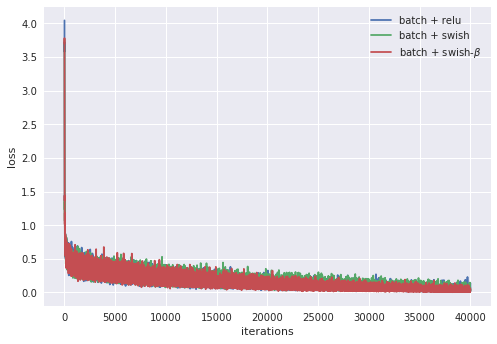

In [18]:
plt.plot(losses, '-', label="batch + relu")
plt.plot(losses_sw, "-", label="batch + swish")
plt.plot(losses_swb, "-", label=r'batch + swish-$\beta$')
plt.legend()
plt.ylabel("loss")
plt.xlabel("iterations")

In [22]:
np.std(losses), np.std(losses_sw), np.std(losses_swb)

(0.12706918, 0.12333465, 0.12854181)

In [23]:
np.std(accuracy), np.std(accuracy_sw), np.std(accuracy_swb)

(0.018506917625579891, 0.016542135404777704, 0.014263791352582243)

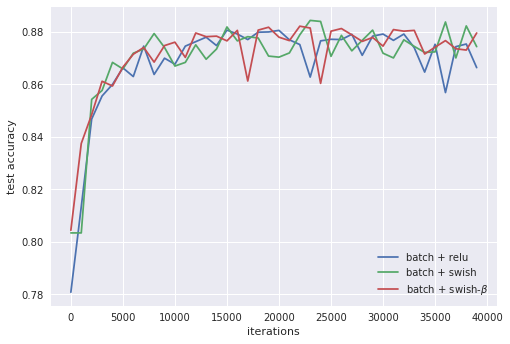

In [19]:
plt.plot(np.arange(0, 40000, 1000), accuracy, '-', label="batch + relu")
plt.plot(np.arange(0, 40000, 1000), accuracy_sw, "-", label="batch + swish")
plt.plot(np.arange(0, 40000, 1000), accuracy_swb, "-", label=r'batch + swish-$\beta$')
plt.legend()
plt.ylabel("test accuracy")
plt.xlabel("iterations")

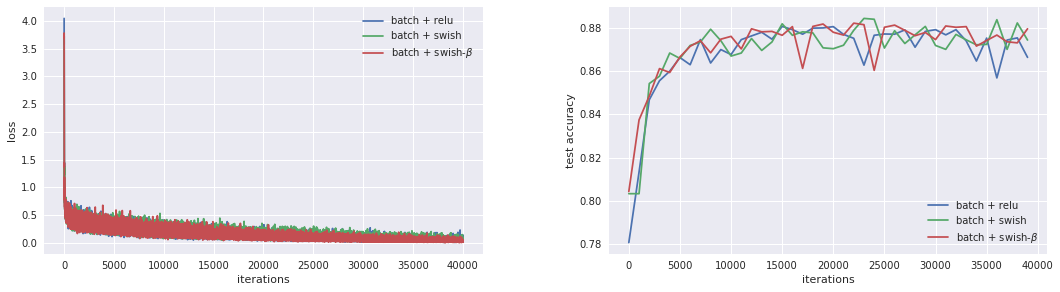

In [20]:
plt.subplot(1, 2, 1)
plt.plot(losses, '-', label="batch + relu")
plt.plot(losses_sw, "-", label="batch + swish")
plt.plot(losses_swb, "-", label=r'batch + swish-$\beta$')
plt.legend()
plt.ylabel("loss")
plt.xlabel("iterations")

plt.subplot(1, 2, 2)
plt.plot(np.arange(0, 40000, 1000), accuracy, '-', label="batch + relu")
plt.plot(np.arange(0, 40000, 1000), accuracy_sw, "-", label="batch + swish")
plt.plot(np.arange(0, 40000, 1000), accuracy_swb, "-", label=r'batch + swish-$\beta$')
plt.legend()
plt.ylabel("test accuracy")
plt.xlabel("iterations")
plt.tight_layout()
fig = plt.gcf()
fig.set_size_inches((16, 4))

In [21]:
fig.savefig("swish.png")

In [24]:
tf.summary.FileWriter(logdir="graph_logs/swish_beta", graph=graph).close()